In [ ]:
from scipy.io import loadmat
from utils import *
data = loadmat('emnist-digits.mat')

In [4]:
import matplotlib.pyplot as plt
import numpy as np


In [5]:
dataset = data['dataset'][0, 0]
train = dataset[0][0, 0]
test = dataset[1][0, 0]
mapping = dataset[2]

train_images = train['images']   # Shape: (N, 28*28)
train_labels = train['labels']  # Shape: (N, 1)
train_writers = train['writers']

In [6]:
X = train_images.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = train_labels.flatten().astype(np.int64)

# Wrap into a datalist with a single client
datalist = [(X, y)]

test_images = test['images'].astype(np.float32) / 255.0
test_labels = test['labels'].flatten().astype(np.int64)


In [7]:
from features_utils import *

[0]


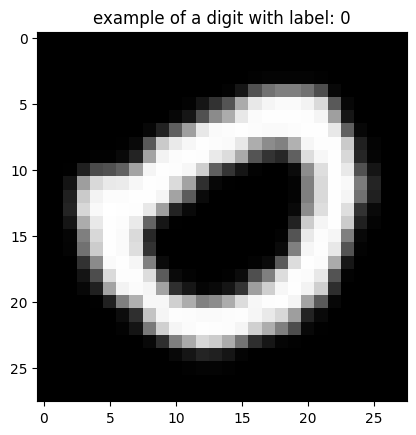

In [8]:
i = 115
img = train_images[i].reshape(28, 28)
print(train_labels[i])
plt.imshow(img, cmap='gray')
plt.title("example of a digit with " +f"label: {train_labels[i][0]}")
plt.show()


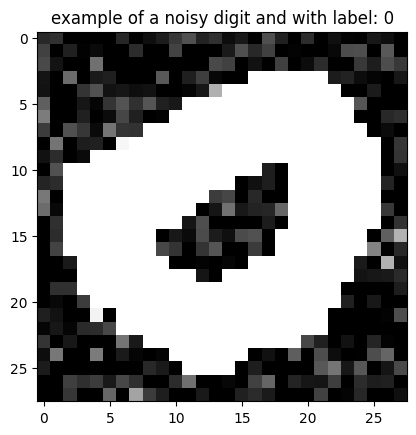

In [9]:
noise_std = 0.25
noised_number = noise_adder(train_images[i],noise_std).reshape(28,28)
plt.imshow(noised_number, cmap='gray')
plt.title("example of a noisy digit and with " +f"label: {train_labels[i][0]}")
plt.show()


In [10]:
n_clients = 30
datalist = make_femnist_datasets(X,y,train,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print(f"case with {n_clients} clients, with feature distribution shift")
model = fedavg(datalist, T, K, gamma)


case with 30 clients, with feature distribution shift
round :  1
round :  2
round :  3
round :  4
round :  5


In [11]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 30 ): 81.27%


In [12]:
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# 1) Create MADE data loaders
made_loaders = [
    DataLoader(
        TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.zeros(len(X), dtype=torch.float32)
        ),
        batch_size=64,
        shuffle=True
    )
    for X, _ in datalist
]

# 2) Train global MADE
global_made = train_global_made(
    made_loaders,
    dim=28*28,
    hid=100,
    rounds=T,
    local_epochs=1
)

# 3) Compute sample-weights alpha for each client
sample_weights = []
for ld in made_loaders:
    local_made = MADE(28*28, 100)
    local_state = train_local_made(local_made, ld, epochs=1)
    local_made.load_state_dict(local_state)

    alpha = compute_sample_weights(global_made, local_made, ld,device = 'cpu')
    # alpha is a FloatTensor of shape [n_samples] for this client
    sample_weights.append(alpha)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Instead of oversampling, just record:
#      - alphas_list (one alpha-tensor per client)
#      - client_sizes (one integer per client)
#    and leave datalist as-is.

alphas_list = sample_weights                  # list of length n_clients, each alpha has shape (N_k,)
client_sizes = [ len(y) for (_, y) in datalist ]  # e.g. [N_1, N_2, ..., N_K]

# 5) Call the fedavg_disk directly on (X,y), alphas_list, and client_sizes
print(f"case with {len(datalist)} clients, with feature distribution shift")
model,loss = fedavg_disk(
    datalist,       # unchanged: [(X1, y1), (X2, y2), …]
    alphas_list,    # per-sample weights from Phase 1
    client_sizes,   # [len(y1), len(y2), …]
    T, K, gamma
)

case with 30 clients, with feature distribution shift


Test Accuracy with 30 ): 89.84%


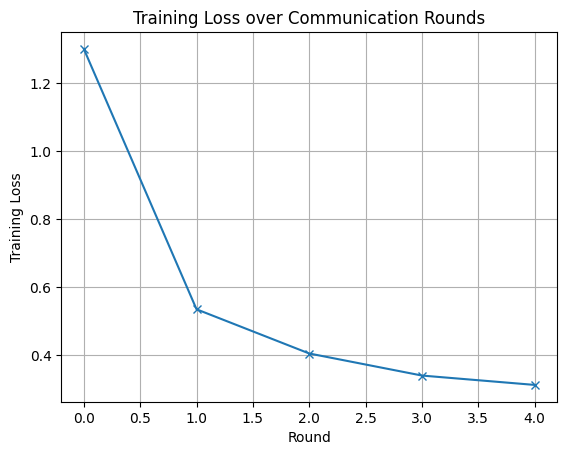

In [13]:
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")
plt.plot(loss, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds")
plt.grid(True)
plt.show()

 ### On obtaining loss curves and convergence rates of the loss function

With loss log

In [14]:
import importlib
import utils
importlib.reload(utils)

from utils import fedavg_loss

In [15]:
# Train

model, loss_curve = fedavg_loss(datalist, T=20, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)
print(abs_dec)
# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")




  Avg training loss at round 10: 1.1296
  Avg training loss at round 20: 0.5952
[0.08053904374440535, 0.09528465270996067, 0.11440904537836705, 0.13193431695302382, 0.14365510145823146, 0.14724957942962646, 0.14282257954279576, 0.13191265265146845, 0.11718354622522997, 0.10127404133478835, 0.08601649999618521, 0.07241656581560774, 0.06081725557645157, 0.051181095838546686, 0.0432856480280559, 0.036841020981470574, 0.031579496463139956, 0.027269336581230208, 0.023720653851826867]
Test Accuracy with 30 ): 86.19%


In [16]:

model, loss_curve = fedavg_disk(datalist,alphas_list,client_sizes, T=20, K=5, gamma=0.1, print_every = 10)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)
print(abs_dec)
# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 0.4465
  Avg training loss at round 20: 0.3406
[0.36050260176293314, 0.4148844616801357, 0.29634240694312675, 0.17509143541158112, 0.1019457410569552, 0.06509406039200627, 0.04249696011940984, 0.03232326263920898, 0.0232851497721554, 0.020469983476319675, 0.01511031400666163, 0.01430745344583767, 0.010721284030522693, 0.010522039818710416, 0.008149994446103426, 0.008144153358945472, 0.006556178314485905, 0.0064610275436775, 0.005522760541932181]
Test Accuracy with 30 ): 90.48%


### Just some plots of loss curve : No relation with convergence rates, just the shape of the loss

In [17]:
model, loss_curve = fedavg_loss(datalist, T=200, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 1.1128
  Avg training loss at round 20: 0.5978
  Avg training loss at round 30: 0.4649
  Avg training loss at round 40: 0.4081
  Avg training loss at round 50: 0.3763
  Avg training loss at round 60: 0.3554
  Avg training loss at round 70: 0.3403
  Avg training loss at round 80: 0.3285
  Avg training loss at round 90: 0.3189
  Avg training loss at round 100: 0.3107
  Avg training loss at round 110: 0.3034
  Avg training loss at round 120: 0.2969
  Avg training loss at round 130: 0.2909
  Avg training loss at round 140: 0.2853
  Avg training loss at round 150: 0.2800
  Avg training loss at round 160: 0.2749
  Avg training loss at round 170: 0.2701
  Avg training loss at round 180: 0.2654
  Avg training loss at round 190: 0.2609
  Avg training loss at round 200: 0.2566
Test Accuracy with 30 ): 93.59%


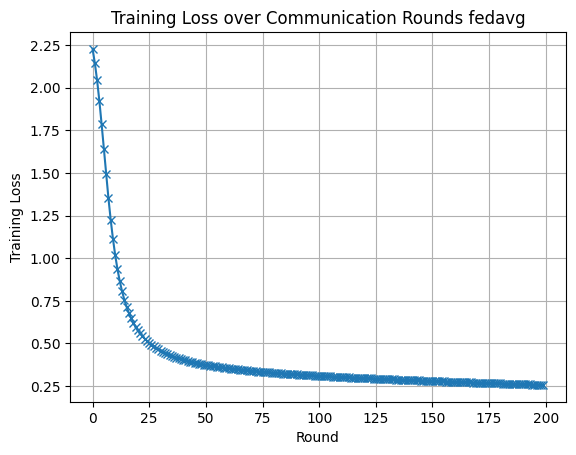

In [18]:
import matplotlib.pyplot as plt

plt.plot(loss_curve, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds fedavg")
plt.grid(True)
plt.show()


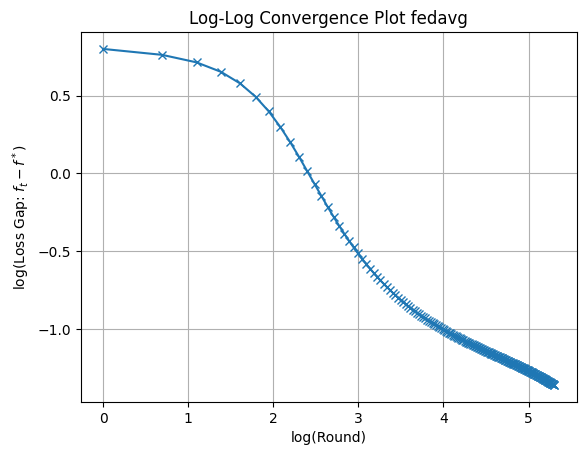

In [19]:
import numpy as np

rounds = np.arange(1, len(loss_curve) + 1)
plt.plot(np.log(rounds), np.log(loss_curve), marker='x')
plt.xlabel("log(Round)")
plt.ylabel("log(Loss Gap: $f_t - f^*$)")
plt.title("Log-Log Convergence Plot fedavg")
plt.grid(True)
plt.show()


In [20]:
model, loss_curve =  fedavg_disk(datalist,alphas_list,client_sizes, T=200, K=5, gamma=0.1, print_every = 10)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 0.4495
  Avg training loss at round 20: 0.3404
  Avg training loss at round 30: 0.3016
  Avg training loss at round 40: 0.2786
  Avg training loss at round 50: 0.2617
  Avg training loss at round 60: 0.2482
  Avg training loss at round 70: 0.2365
  Avg training loss at round 80: 0.2264
  Avg training loss at round 90: 0.2172
  Avg training loss at round 100: 0.2090
  Avg training loss at round 110: 0.2013
  Avg training loss at round 120: 0.1945
  Avg training loss at round 130: 0.1883
  Avg training loss at round 140: 0.1826
  Avg training loss at round 150: 0.1774
  Avg training loss at round 160: 0.1725
  Avg training loss at round 170: 0.1681
  Avg training loss at round 180: 0.1639
  Avg training loss at round 190: 0.1601
  Avg training loss at round 200: 0.1564
Test Accuracy with 30 ): 95.49%


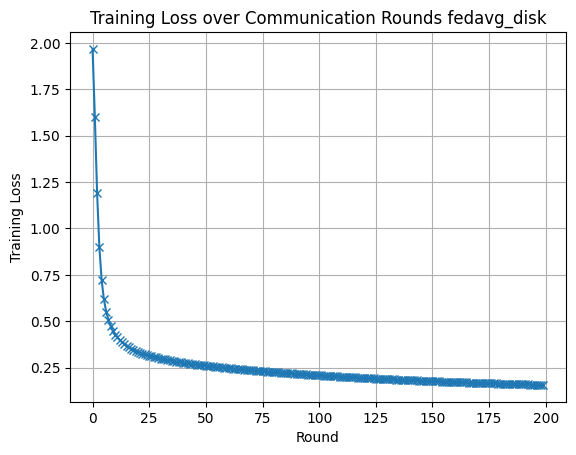

In [21]:
plt.plot(loss_curve, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds fedavg_disk")
plt.grid(True)
plt.show()

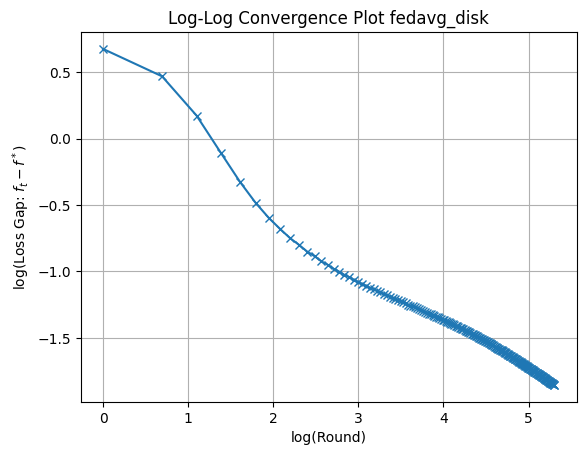

In [22]:
rounds = np.arange(1, len(loss_curve) + 1)
plt.plot(np.log(rounds), np.log(loss_curve), marker='x')
plt.xlabel("log(Round)")
plt.ylabel("log(Loss Gap: $f_t - f^*$)")
plt.title("Log-Log Convergence Plot fedavg_disk")
plt.grid(True)
plt.show()
